# Deep learning with Python

# 03. Getting started with neural networks

# 3.6 회귀 문제 : 보스턴 주택 가격 데이터셋을 이용한 가격 예측

## 데이터 불러오기

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(train_targets.shape)

(404, 13)
(404,)
(102, 13)
(404,)


In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
train_targets[0:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

변수 특성은 다음과 같습니다.

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

타깃은 주택의 중간 가격으로 천달러 단위입니다

이제 기후 변화로 해안가 근처의 집들의 가격이 내려가고 있다던데 나중엔 이런 집값 관련 예제 데이터도 바뀌겠네

## 데이터 준비

변수의 스케일이 다르기 때문에 표준화 or 정규화 등의 방법을 이용해 스케일을 맞춰준다

In [5]:
import numpy as np

In [6]:
# 표준화 class 생성

class Scaler:

    def __init__(self):
        self.mean = 0
        self.std = 0

    def fit(self, data):
        self.mean = np.mean(data, axis = 0)
        self.std = np.std(data, axis = 0)

    def transform(self, data):
        result = (data - self.mean) / self.std
        return result

    def invernse_transform(self, data):
        result = data * self.std + self.mean
        return result

In [7]:
# data와 target을 각각 표준화해준다.

x_scaler = Scaler()

x_scaler.fit(train_data)

std_train_data = x_scaler.transform(train_data)
std_test_data = x_scaler.transform(test_data)


y_scaler = Scaler()

y_scaler.fit(train_targets)

std_train_targets = y_scaler.transform(train_targets)
std_test_targets = y_scaler.transform(test_targets)

In [8]:
std_train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## 모델 구성 및 교차 검증

In [9]:
import tensorflow as tf
from keras import models, layers

def build_model():

    tf.random.set_seed(20152410)
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer = 'rmsprop',
                  loss = 'mse',
                  metrics = ['mae'])
    
    return model

In [10]:
def cross_validation_model(train_data, train_targets, cv, epochs):

    k = cv
    n = train_data.shape[0]
    num_val_samples = n // 4
    num_epochs = epochs
    history_record = []

    for i in range(k):
        print("처리중인 폴드 : {}".format(i))

        # train과 validation의 인덱스 구성
        train_sample0 = np.arange(0, i * num_val_samples)
        train_sample1 = np.arange((i + 1) * num_val_samples, n)
        train_samples = np.concatenate([train_sample0, train_sample1])
        val_samples = np.arange(i * num_val_samples, (i + 1) * num_val_samples)
        
        # train과 validation 구성
        x_train = train_data[train_samples]
        y_train = train_targets[train_samples]
        x_val = train_data[val_samples]
        y_val = train_targets[val_samples]

        # 모델 학습
        model = build_model()
        history = model.fit(x_train,
                            y_train,
                            epochs = num_epochs,
                            verbose = 0,
                            validation_data = (x_val, y_val))
        
        history_record.append(history.history)

    return history_record

In [11]:
# epochs를 500으로 지정해서 학습 후 history 확인을 통해 epochs 결정

history_record = cross_validation_model(train_data = std_train_data,
                                        train_targets = std_train_targets,
                                        cv = 4,
                                        epochs = 500)

처리중인 폴드 : 0
처리중인 폴드 : 1
처리중인 폴드 : 2
처리중인 폴드 : 3


In [12]:
def cv_result(history, keys):

    n = len(history)
    result = np.zeros((len(history[0][keys]), ))
    
    for i in range(n):
        result += np.array(history[i][keys])

    result = result / n
    return result

In [13]:
cv_loss = cv_result(history_record, keys = "loss")
cv_mae = cv_result(history_record, keys = "mae")
cv_val_loss = cv_result(history_record, keys = "val_loss")
cv_val_mae = cv_result(history_record, keys = "val_mae")

In [14]:
import matplotlib
import matplotlib.pyplot as plt

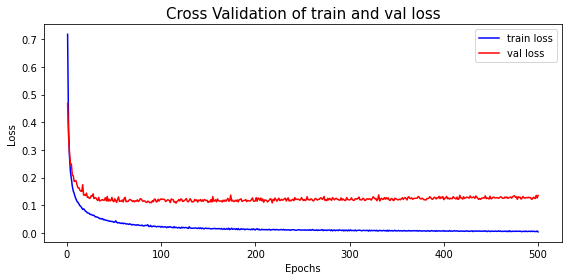

In [15]:
# train loss, validation loss 그래프 확인

epochs = np.arange(1, 501)

plt.figure(figsize = (8, 4))
plt.plot(epochs, cv_loss, 'b-', label = "train loss", markersize = 3)
plt.plot(epochs, cv_val_loss, 'r-', label = "val loss", markersize = 3)

plt.title("Cross Validation of train and val loss", fontsize = 15)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

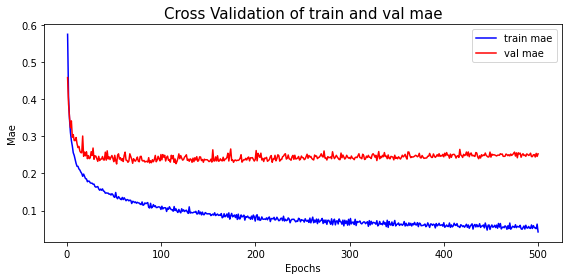

In [16]:
# train loss, validation loss 그래프 확인

epochs = np.arange(1, 501)

plt.figure(figsize = (8, 4))
plt.plot(epochs, cv_mae, 'b-', label = "train mae", markersize = 3)
plt.plot(epochs, cv_val_mae, 'r-', label = "val mae", markersize = 3)

plt.title("Cross Validation of train and val mae", fontsize = 15)
plt.xlabel("Epochs")
plt.ylabel('Mae')
plt.legend()

plt.tight_layout()
plt.show()

40 ~ 60 정도만 되도 validation loss와 validation mae는 더 이상 감소하지 않는 것을 확인할 수 있다.

In [17]:
np.argmin(cv_val_mae)

52

52번째 epochs에서 cv validation mae가 가장 작은 값을 기록한다. 따라서 epochs = 52로 최종 모델을 학습하고 난 후 target을 원래의 스케일로 바꿔준 뒤 최종 모델의 성능 평가를 진행하도록 하겠다.

## 최종 모델 학습 및 결과 평가

In [18]:
model = build_model()

# cv 결과로 가장 적합하다고 평가받았던 epochs = 52를 이용하여 모델 학습

model.fit(std_train_data,
          std_train_targets,
          epochs = 52)

result = model.evaluate(std_test_data, std_test_targets)

Epoch 1/52
13/13 [==============================] - 1s 2ms/step - loss: 0.7137 - mae: 0.5798
Epoch 2/52
13/13 [==============================] - 0s 3ms/step - loss: 0.3115 - mae: 0.3640
Epoch 3/52
13/13 [==============================] - 0s 2ms/step - loss: 0.2677 - mae: 0.3430
Epoch 4/52
13/13 [==============================] - 0s 2ms/step - loss: 0.2382 - mae: 0.3054
Epoch 5/52
13/13 [==============================] - 0s 2ms/step - loss: 0.2354 - mae: 0.2931
Epoch 6/52
13/13 [==============================] - 0s 2ms/step - loss: 0.1759 - mae: 0.2586
Epoch 7/52
13/13 [==============================] - 0s 3ms/step - loss: 0.1216 - mae: 0.2272
Epoch 8/52
13/13 [==============================] - 0s 2ms/step - loss: 0.1550 - mae: 0.2461
Epoch 9/52
13/13 [==============================] - 0s 2ms/step - loss: 0.1235 - mae: 0.2367
Epoch 10/52
13/13 [==============================] - 0s 2ms/step - loss: 0.1280 - mae: 0.2305
Epoch 11/52
13/13 [==============================] - 0s 2ms/step - lo

In [19]:
print("최종 모델의 표준화된 test target에 대한 mse : {}".format(result[0]))
print("최종 모델의 표준화된 test target에 대한 mae : {}".format(result[1]))

pred_std_y_test = model.predict(std_test_data)
pred_y_test = y_scaler.invernse_transform(pred_std_y_test).reshape(-1)

test_mse = np.mean((test_targets - pred_y_test)**2)
test_mae = np.mean(np.abs(test_targets - pred_y_test))

print("최종 모델의 test mse : {}".format(test_mse))
print("최종 모델의 test mse : {}".format(test_mae))

최종 모델의 표준화된 test target에 대한 mse : 0.18589599430561066
최종 모델의 표준화된 test target에 대한 mae : 0.28617045283317566
최종 모델의 test mse : 15.73093703001637
최종 모델의 test mse : 2.6324919775420548
